
===== TOY_SIZE = 16 =====
T = 5
T = 10
T = 40
T = 80
T = 200
T = 400
T = 600
T = 1000


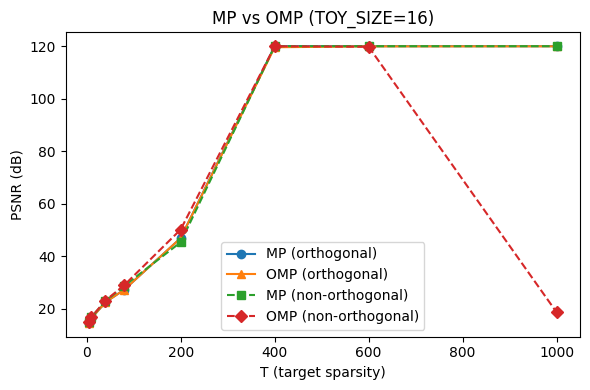


===== PSNR SUMMARY for TOY_SIZE = 16 =====
     T |   MP (ortho) |  OMP (ortho) |  MP (non-ortho) | OMP (non-ortho)
----------------------------------------------------------------------
     5 |       14.714 |       14.714 |          14.920 |          14.920
    10 |       16.483 |       16.483 |          16.922 |          16.922
    40 |       22.557 |       22.557 |          23.011 |          23.218
    80 |       27.368 |       27.368 |          28.800 |          29.074
   200 |       46.963 |       46.963 |          45.392 |          50.238
   400 |      119.982 |      119.571 |         119.977 |         119.949
   600 |      119.983 |      119.901 |         119.979 |         119.759
  1000 |      119.983 |      119.926 |         119.979 |          18.735


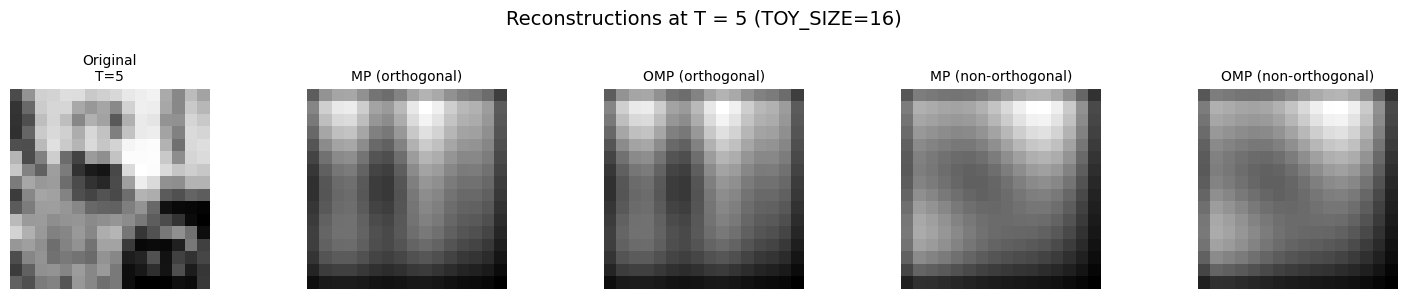

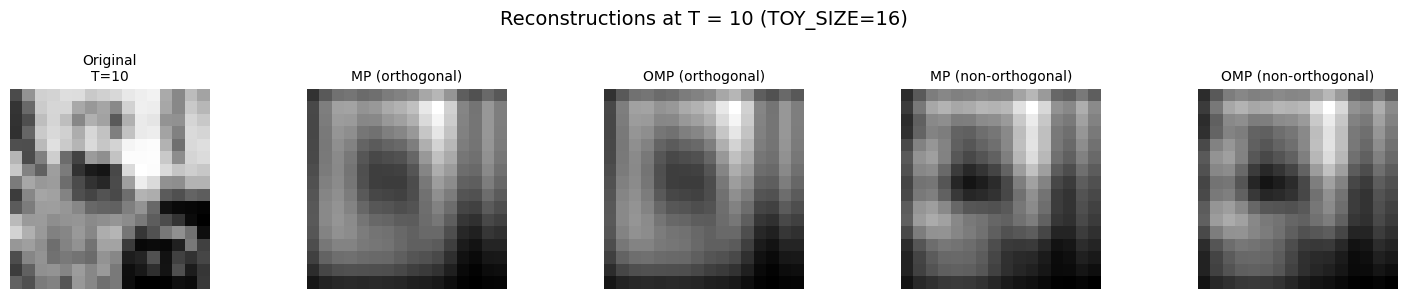

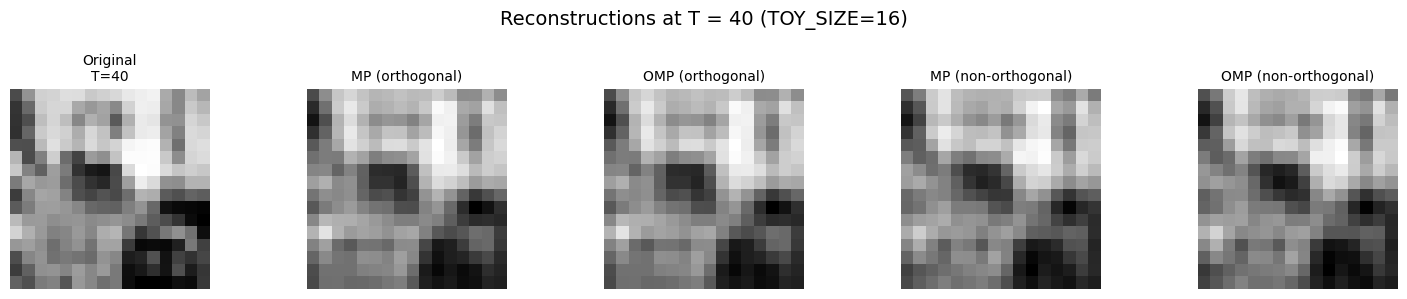

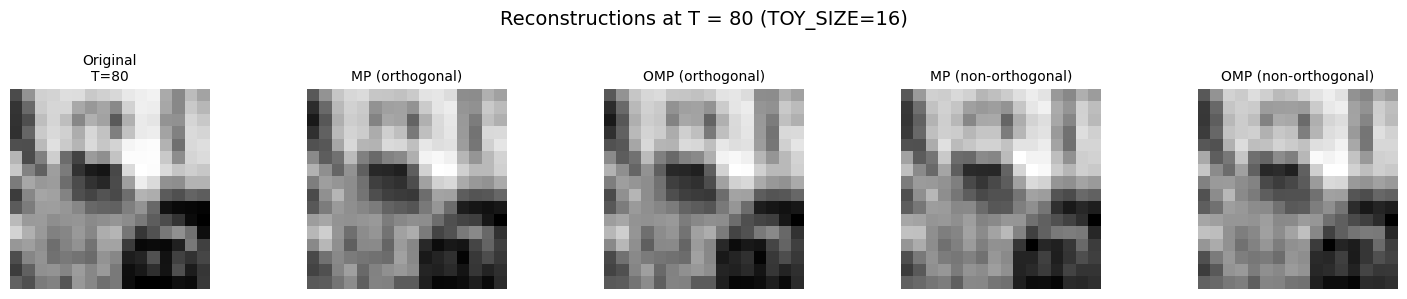

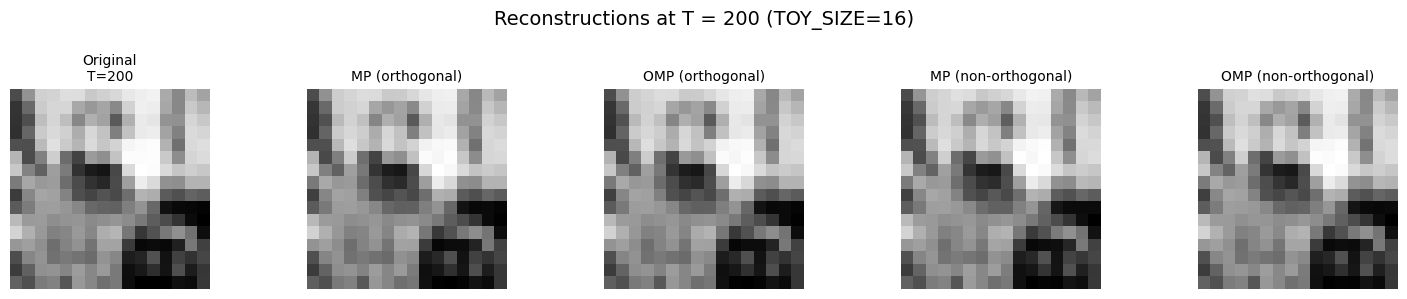

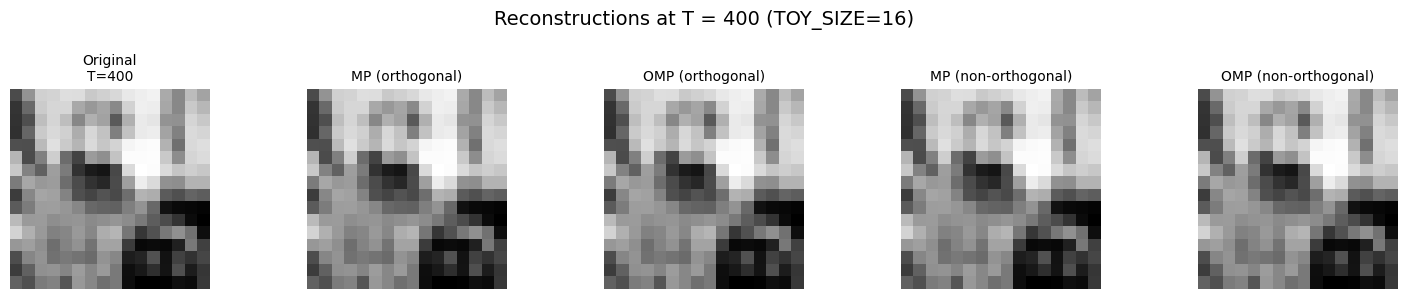

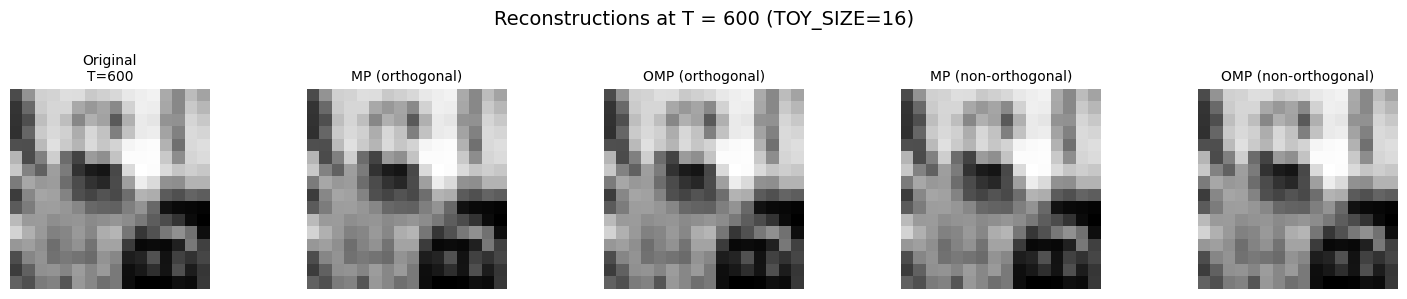

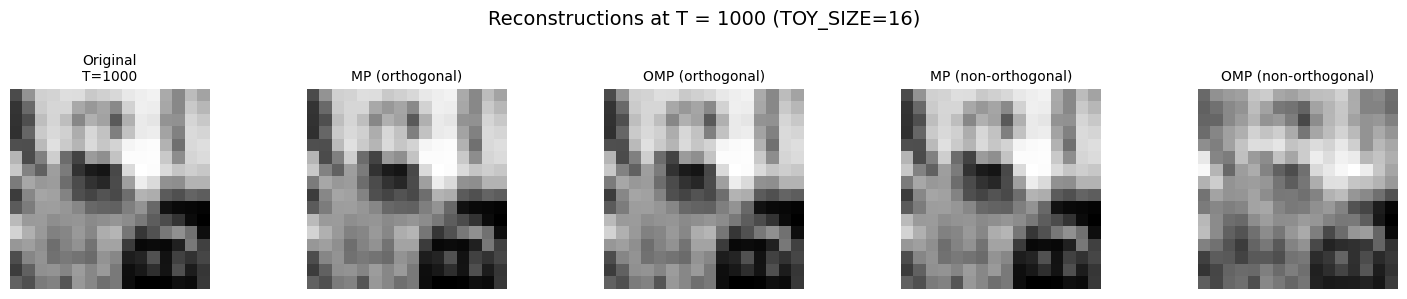


===== TOY_SIZE = 32 =====
T = 5
T = 10
T = 40
T = 80
T = 200
T = 400
T = 600
T = 1000


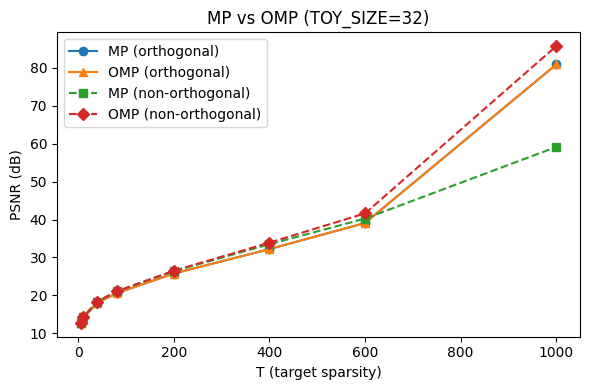


===== PSNR SUMMARY for TOY_SIZE = 32 =====
     T |   MP (ortho) |  OMP (ortho) |  MP (non-ortho) | OMP (non-ortho)
----------------------------------------------------------------------
     5 |       12.767 |       12.767 |          12.867 |          12.867
    10 |       14.121 |       14.121 |          14.323 |          14.323
    40 |       18.057 |       18.057 |          18.370 |          18.370
    80 |       20.588 |       20.588 |          21.082 |          21.082
   200 |       25.768 |       25.768 |          26.389 |          26.517
   400 |       32.211 |       32.211 |          33.496 |          33.906
   600 |       39.083 |       39.083 |          40.253 |          41.619
  1000 |       80.853 |       80.853 |          59.108 |          85.679


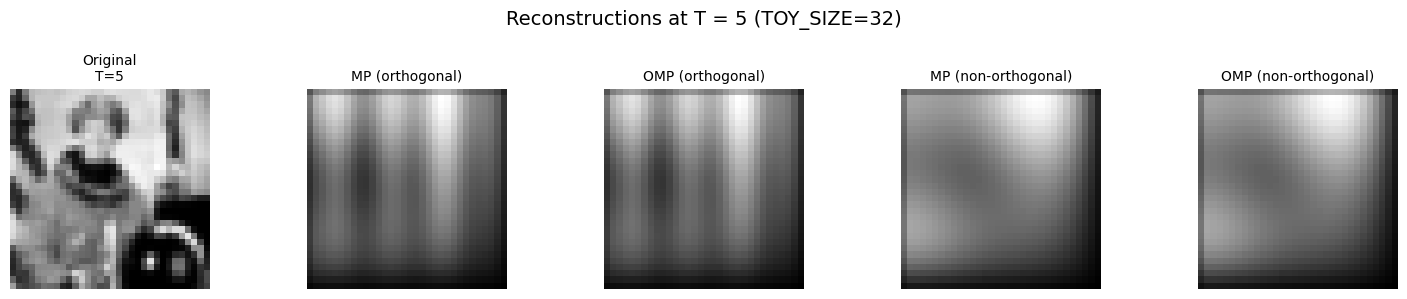

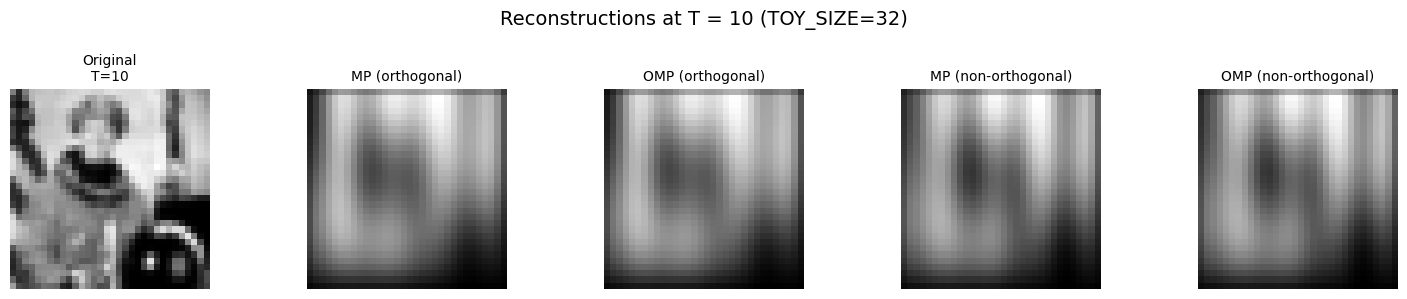

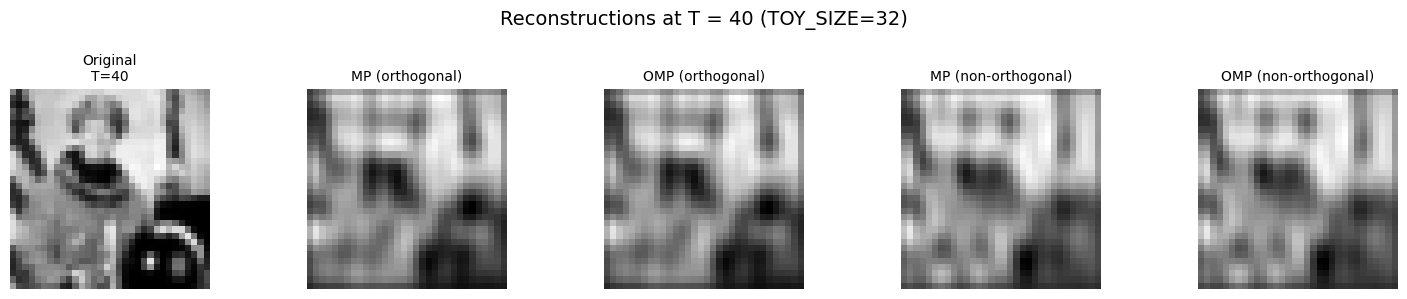

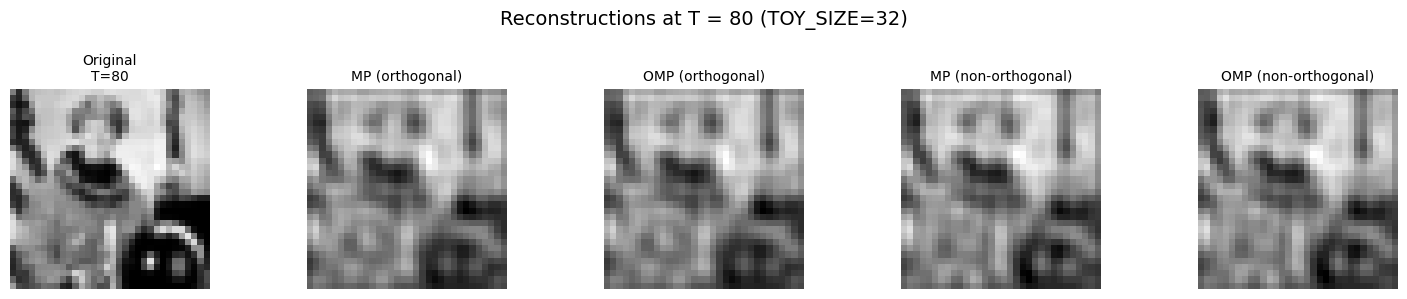

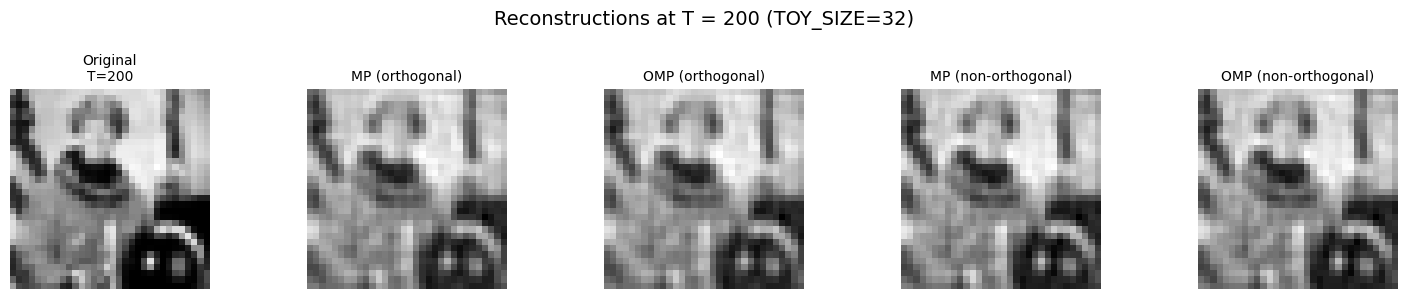

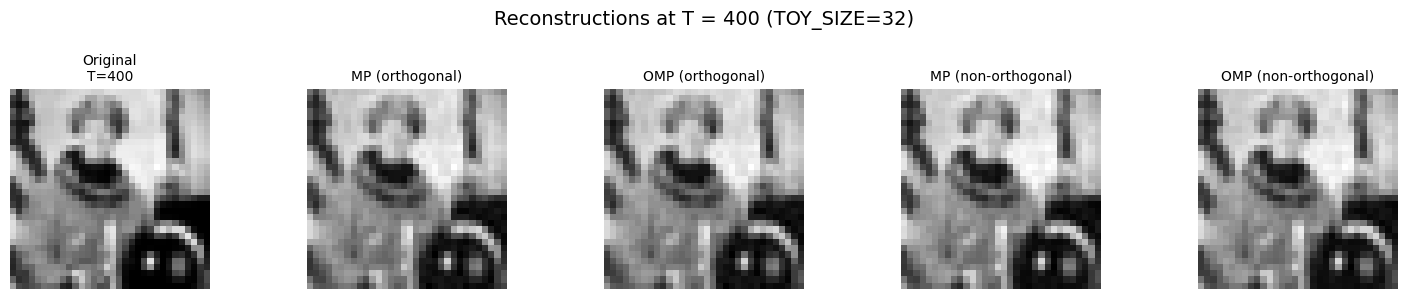

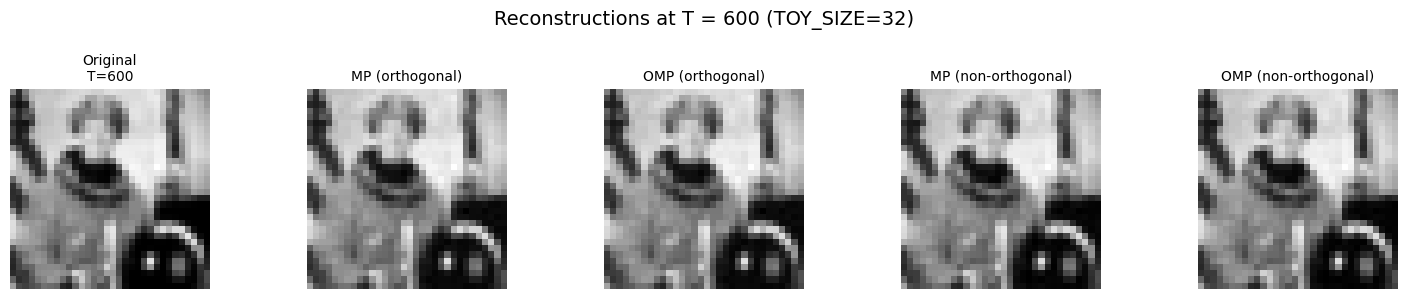

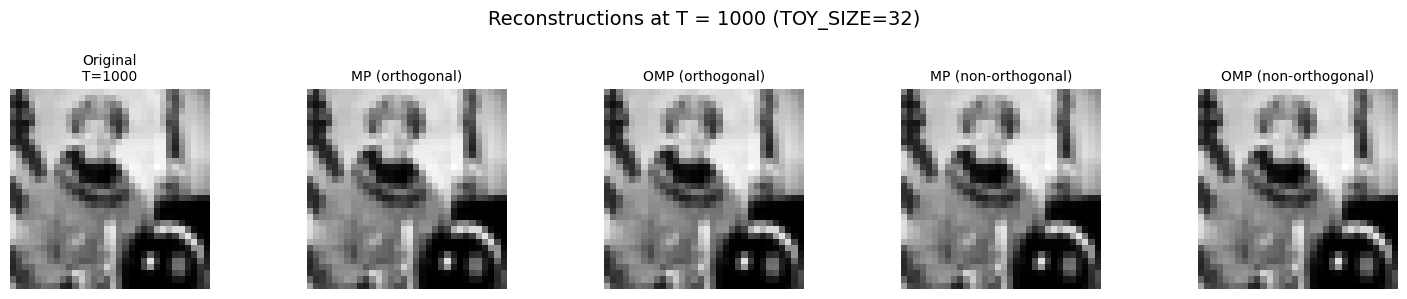


===== TOY_SIZE = 64 =====
T = 5
T = 10
T = 40
T = 80
T = 200
T = 400
T = 600
T = 1000


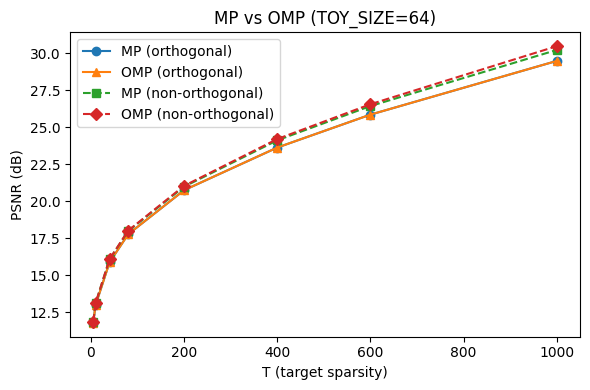


===== PSNR SUMMARY for TOY_SIZE = 64 =====
     T |   MP (ortho) |  OMP (ortho) |  MP (non-ortho) | OMP (non-ortho)
----------------------------------------------------------------------
     5 |       11.784 |       11.784 |          11.852 |          11.852
    10 |       12.982 |       12.982 |          13.106 |          13.106
    40 |       15.878 |       15.878 |          16.084 |          16.084
    80 |       17.775 |       17.775 |          17.989 |          18.024
   200 |       20.754 |       20.754 |          20.992 |          21.049
   400 |       23.638 |       23.638 |          24.126 |          24.213
   600 |       25.865 |       25.865 |          26.445 |          26.568
  1000 |       29.496 |       29.496 |          30.236 |          30.492


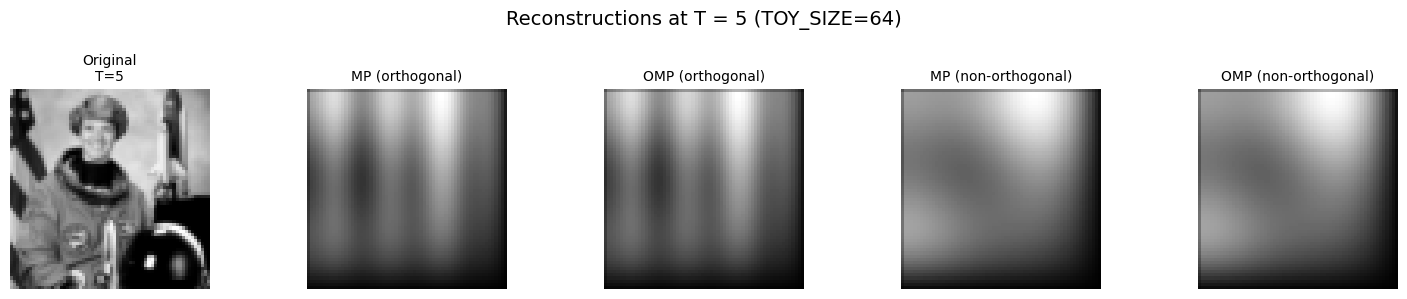

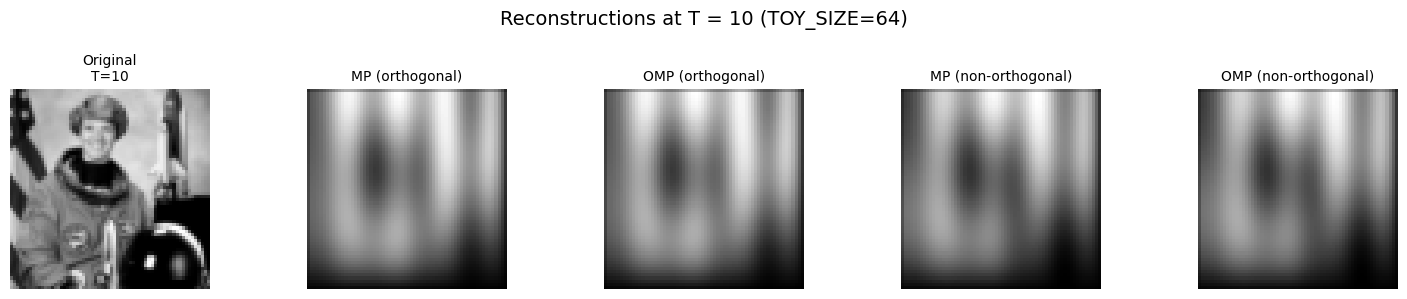

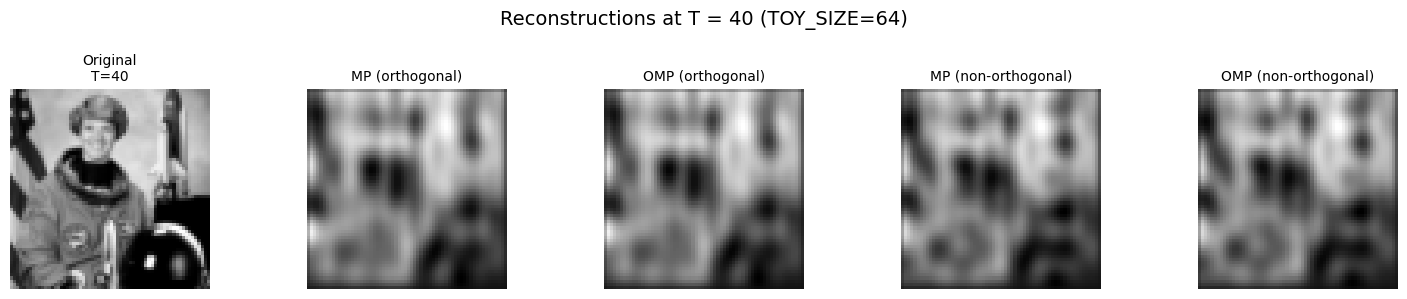

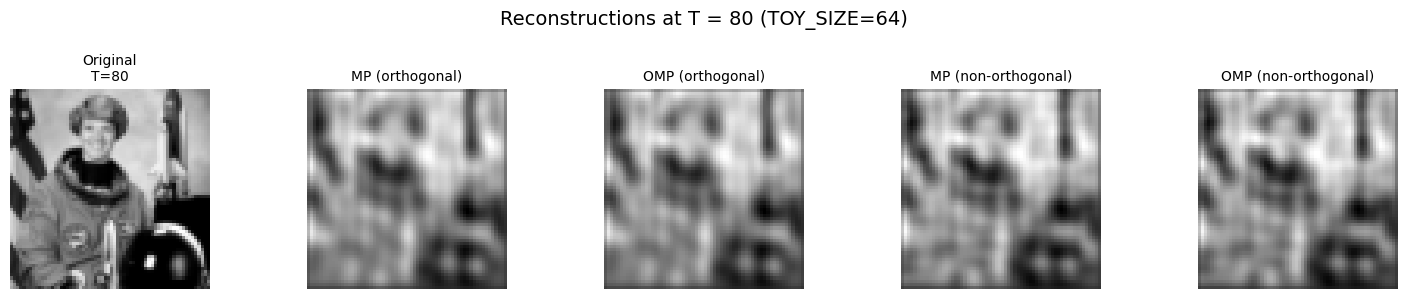

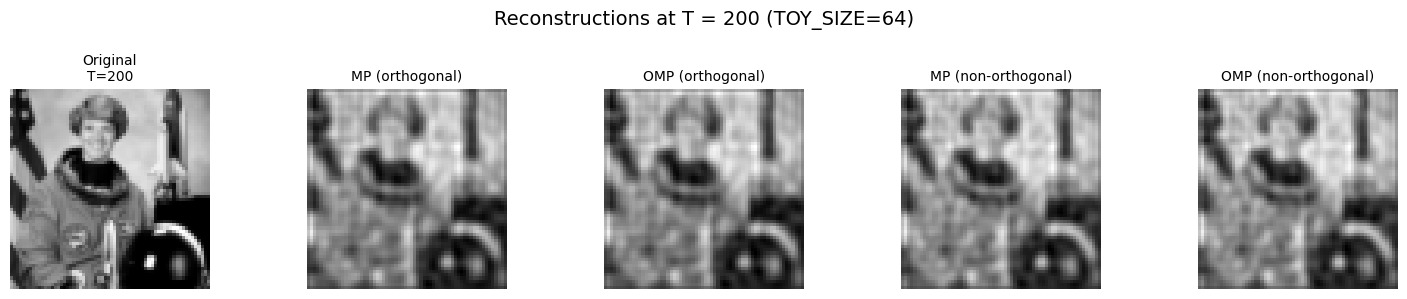

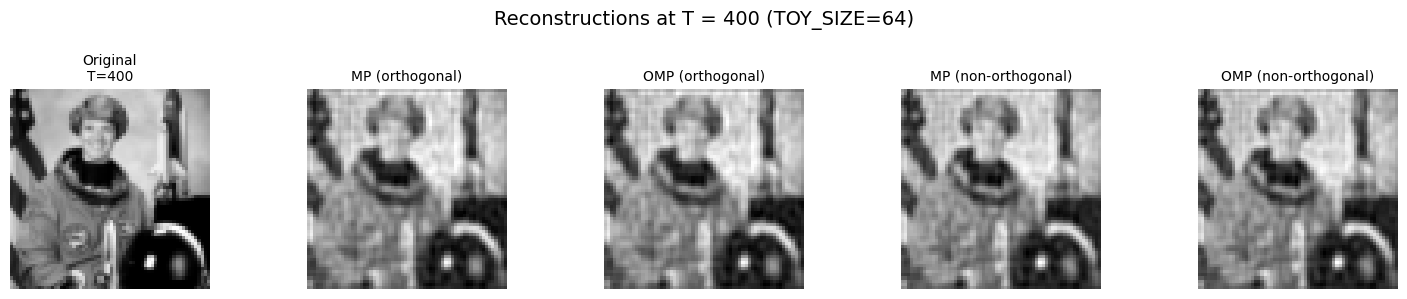

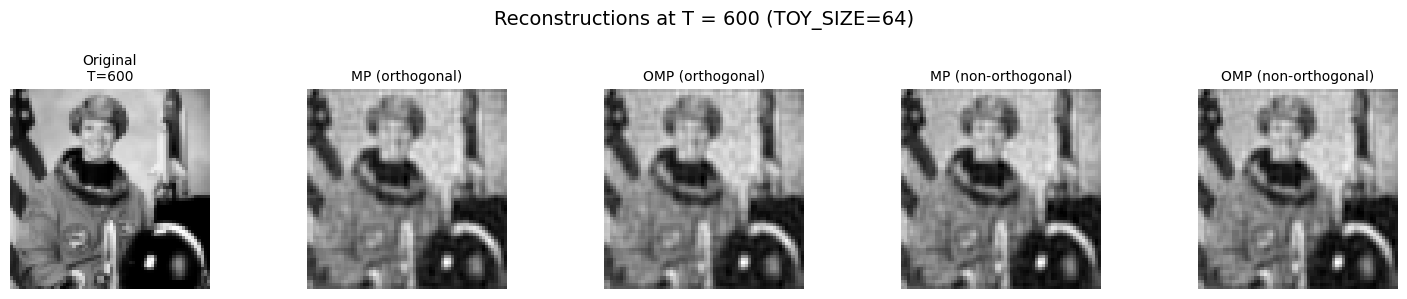

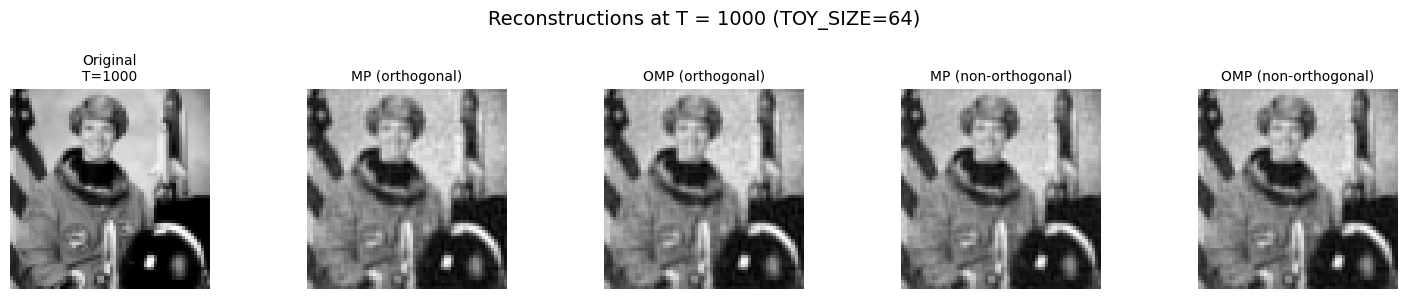

In [2]:
import os, math, numpy as np, torch
import matplotlib.pyplot as plt
from skimage import data, color, transform

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.makedirs("results", exist_ok=True)

# --- Utilities ---
def psnr_vec(x, xh, eps=1e-12):
    x, xh = x.reshape(-1), xh.reshape(-1)
    mse = torch.mean((xh - x) ** 2)
    return float(10.0 * torch.log10(1.0 / (mse + eps)))

_DCT_CACHE = {}
def _dct_mat(N, device, dtype):
    key = (N, str(device), str(dtype))
    if key in _DCT_CACHE:
        return _DCT_CACHE[key]
    n = torch.arange(N, device=device, dtype=dtype).unsqueeze(0)
    k = torch.arange(N, device=device, dtype=dtype).unsqueeze(1)
    C = torch.cos((math.pi / N) * (n + 0.5) * k)
    C[0, :] *= (1.0 / math.sqrt(N))
    C[1:, :] *= math.sqrt(2.0 / N)
    _DCT_CACHE[key] = C
    return C

def build_orthonormal_dct_dict(N):
    C = _dct_mat(N, torch.device("cpu"), torch.float32)
    U2D = torch.kron(C, C)
    U2D = U2D / (torch.norm(U2D, dim=0, keepdim=True) + 1e-12)
    return U2D

def make_nonorth_overcomplete(U_cpu, alpha=0.95):
    n = U_cpu.shape[1]
    I = torch.eye(n)
    P = torch.roll(I, shifts=1, dims=1)
    V = U_cpu @ (I + alpha * P)
    V = V / (torch.norm(V, dim=0, keepdim=True) + 1e-12)
    return torch.cat([U_cpu, V], dim=1)

# --- Algorithms ---
def mp_explicit(y_vec, D, T):
    y = y_vec.clone()
    n, m = D.shape
    a = torch.zeros(m, device=D.device, dtype=D.dtype)
    r = y.clone()
    Dt = D.t()
    for _ in range(T):
        c = Dt @ r
        j = int(torch.argmax(torch.abs(c)))
        a[j] = a[j] + c[j]
        r = r - D[:, j] * c[j]
    return D @ a, a

def omp_explicit(y_vec, D, T):
    y = y_vec.clone()
    n, m = D.shape
    S = []
    a = torch.zeros(m, device=D.device, dtype=D.dtype)
    Dt = D.t()
    r = y.clone()
    for _ in range(T):
        c = Dt @ r
        j = int(torch.argmax(torch.abs(c)))
        if j not in S:
            S.append(j)
        Ds = D[:, S]
        a_S, *_ = torch.linalg.lstsq(Ds, y,rcond=1e-6)
        r = y - Ds @ a_S
    a[S] = a_S
    return D @ a, a, S

# --- Image sizes to test ---
toy_sizes = [16, 32, 64]
T_vals = [5, 10, 40, 80, 200, 400, 600, 1000]

for TOY_SIZE in toy_sizes:
    print(f"\n===== TOY_SIZE = {TOY_SIZE} =====")

    # Load image
    img = transform.resize(color.rgb2gray(data.astronaut()), (TOY_SIZE, TOY_SIZE), anti_aliasing=True).astype(np.float32)
    x_cpu = torch.from_numpy(img).float().cpu()
    y_vec = x_cpu.reshape(-1)

    # Dictionaries
    U = build_orthonormal_dct_dict(TOY_SIZE)
    D_non = make_nonorth_overcomplete(U, alpha=0.95)

    # Run MP/OMP
    ps_mp_ortho, ps_omp_ortho, ps_mp_non, ps_omp_non = [], [], [], []
    recons_all = {}

    for T in T_vals:
        print(f"T = {T}")
        xh_mp_ortho, _ = mp_explicit(y_vec, U, T)
        xh_omp_ortho, _, _ = omp_explicit(y_vec, U, T)
        xh_mp_non, _ = mp_explicit(y_vec, D_non, T)
        xh_omp_non, _, _ = omp_explicit(y_vec, D_non, T)

        ps_mp_ortho.append(psnr_vec(y_vec, xh_mp_ortho))
        ps_omp_ortho.append(psnr_vec(y_vec, xh_omp_ortho))
        ps_mp_non.append(psnr_vec(y_vec, xh_mp_non))
        ps_omp_non.append(psnr_vec(y_vec, xh_omp_non))

        recons_all[T] = {
            "MP (orthogonal)": xh_mp_ortho.reshape(TOY_SIZE, TOY_SIZE),
            "OMP (orthogonal)": xh_omp_ortho.reshape(TOY_SIZE, TOY_SIZE),
            "MP (non-orthogonal)": xh_mp_non.reshape(TOY_SIZE, TOY_SIZE),
            "OMP (non-orthogonal)": xh_omp_non.reshape(TOY_SIZE, TOY_SIZE),
        }

    # Plot PSNR vs T
    Ta = np.array(T_vals, dtype=float)
    plt.figure(figsize=(6, 4))
    plt.plot(Ta, ps_mp_ortho, "o-", label="MP (orthogonal)")
    plt.plot(Ta, ps_omp_ortho, "^-", label="OMP (orthogonal)")
    plt.plot(Ta, ps_mp_non, "s--", label="MP (non-orthogonal)")
    plt.plot(Ta, ps_omp_non, "D--", label="OMP (non-orthogonal)")
    plt.xlabel("T (target sparsity)")
    plt.ylabel("PSNR (dB)")
    plt.title(f"MP vs OMP (TOY_SIZE={TOY_SIZE})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"results/psnr_vs_T_size{TOY_SIZE}.png", dpi=150)
    plt.show()

    print(f"\n===== PSNR SUMMARY for TOY_SIZE = {TOY_SIZE} =====")
    print(f"{'T':>6} | {'MP (ortho)':>12} | {'OMP (ortho)':>12} | {'MP (non-ortho)':>15} | {'OMP (non-ortho)':>15}")
    print("-" * 70)
    for T, ps1, ps2, ps3, ps4 in zip(T_vals, ps_mp_ortho, ps_omp_ortho, ps_mp_non, ps_omp_non):
        print(f"{T:6d} | {ps1:12.3f} | {ps2:12.3f} | {ps3:15.3f} | {ps4:15.3f}")

    # Visualize reconstructions: one plot per T
    for T in T_vals:
        fig, axes = plt.subplots(1, 5, figsize=(15, 3))

        # Original image
        axes[0].imshow(img, cmap="gray")
        axes[0].set_title(f"Original\nT={T}", fontsize=10)

        # Reconstructed images
        for ax, (title, rec) in zip(axes[1:], recons_all[T].items()):
            ax.imshow(rec, cmap="gray")
            ax.set_title(title, fontsize=10)

        # Turn off axes
        for ax in axes:
            ax.axis("off")

        plt.suptitle(f"Reconstructions at T = {T} (TOY_SIZE={TOY_SIZE})", fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.savefig(f"results/reconstructions_T{T}_size{TOY_SIZE}.png", dpi=150)
        plt.show()
